In [118]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import pandas as pd
import scipy
from numpy import mean, cov
from numpy.linalg import eigh
import math
import sys

%matplotlib inline

In [119]:
def plot_graph(k, labels, predicted_labels):
    hist = []
    for i in range(k):
        hist.append([])
    
    for i in range(len(labels)):
        hist[labels[i]].append(predicted_labels[i])

    plt.hist(hist)

In [116]:
def pca(data):
    cova = cov(data.T) 
    values, vectors = eigh(cova)
    idx = np.argsort(values)[::-1]
    values = np.real(values[idx])
    vectors = np.real(vectors.T[idx])
    return values, vectors

In [124]:
def kmeans(points, k, epochs=10000, centroids=None):
    not_finished = True
    if centroids is None:
        random_mask = np.random.choice(points.shape[0], k, replace=False)
        centroids = points[random_mask, :]
    epoch = 0
    labels = []
    
    while not_finished and epoch < epochs:
        labels = []

        for point in points:
            shortest_i, shortest_distance = None, 10000000000
            for i, centroid in enumerate(centroids):
                distance = scipy.spatial.distance.euclidean(point, centroid)
                if distance <= shortest_distance:
                    shortest_distance = distance
                    shortest_i = i
            labels.append(shortest_i)

        labels = np.array(labels)
        not_finished = False

        for i in range(k):
            new_centroid = np.mean(points[np.where(labels == i)], axis=0)
            if not np.all(np.isclose(new_centroid, centroids[i])):
                centroids[i] = new_centroid
                not_finished = True

        if epoch != 0 and epoch % (epochs // 10) == 0:
            print(epoch)
        epoch = epoch + 1
        
    return labels, centroids


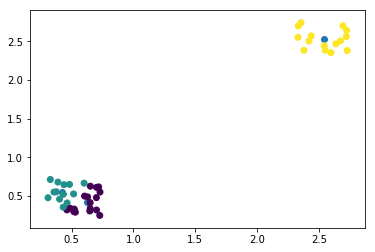

In [125]:
k = 3
points = []
for i in range(k):
    points.extend((np.random.rand(15, 2)) / 2 + (i - 1.5) * (i - 1.5))

points = np.array(points)
labels, centroids = kmeans(points, k)

plt.scatter(centroids[:, 0], centroids[:, 1])
plt.scatter(points[:, 0], points[:, 1], c=labels)

In [102]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_train = x_train.astype('float32') / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])
x_test = x_test.astype('float32') / 255.0

Masks to select 0 and 1 labels.
Only train on 500 elements from 2 selected classes for prototyping purposes.

In [103]:
mask_0 = np.where(y_train == 0)
mask_1 = np.where(y_train == 1)

In [104]:
sub_x_train = np.concatenate((x_train[mask_0][:500], x_train[mask_1][:500]))
sub_y_train = np.concatenate((y_train[mask_0][:500], y_train[mask_1][:500]))

In [126]:
labels, centroids = kmeans(x_train, 10, epochs=100)

KeyboardInterrupt: 

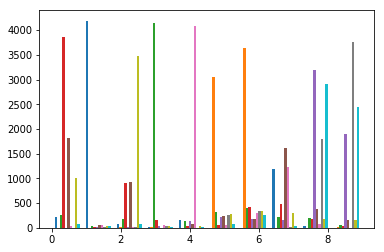

In [115]:
plot_graph(10, y_train, labels.astype('uint8'))

In [130]:
dims = 2
values, vectors = pca(x_train)
compressed_pca = x_train.dot(vectors[:dims].T)
compressed_pca.shape


(60000, 2)

In [128]:
labels, centroids = kmeans(compressed_pca, 10, epochs=100)

10
20
30
40
50
60
70


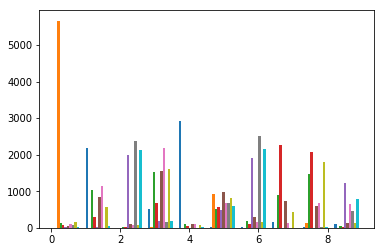

In [129]:
plot_graph(10, y_train, labels.astype('uint8'))

## Autoencoder

In [70]:
from keras.layers import Input, Dense
from keras.models import Model

In [71]:
x_train.shape

(60000, 784)

In [74]:
encoding_dim = 32  

input_img = Input(shape=(x_train.shape[1],))

encoded = Dense(encoding_dim, activation='relu')(input_img)

decoded = Dense(x_train.shape[1], activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)


encoded_input = Input(shape=(encoding_dim,))

decoder_layer = autoencoder.layers[-1]

decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [95]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.1040 - acc: 0.8134 - val_loss: 0.1022 - val_acc: 0.8125
Epoch 2/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.1037 - acc: 0.8134 - val_loss: 0.1019 - val_acc: 0.8126
Epoch 3/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.1034 - acc: 0.8134 - val_loss: 0.1016 - val_acc: 0.8126
Epoch 4/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.1031 - acc: 0.8135 - val_loss: 0.1014 - val_acc: 0.8126
Epoch 5/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.1029 - acc: 0.8135 - val_loss: 0.1011 - val_acc: 0.8126
Epoch 6/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.1026 - acc: 0.8135 - val_loss: 0.1009 - val_acc: 0.8127
Epoch 7/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.1024 - acc: 0.8135 - val_loss: 0.1007 - val_acc

In [131]:
encoding_dim = 2  

dims = x_train.shape[1]
values, vectors = pca(x_train)
compressed_pca = x_train.dot(vectors[:dims].T)

input_img = Input(shape=(x_train.shape[1],))

encoded = Dense(encoding_dim, activation='relu')(input_img)

decoded = Dense(x_train.shape[1], activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)


encoded_input = Input(shape=(encoding_dim,))

decoder_layer = autoencoder.layers[-1]

decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [132]:
compressed_pca.shape

(60000, 784)

In [133]:
autoencoder.fit(compressed_pca, compressed_pca,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.0340 - acc: 0.0186 - val_loss: 0.5888 - val_acc: 0.8007
Epoch 2/50
60000/60000 [==============================] - 2s 32us/step - loss: -0.2782 - acc: 0.0204 - val_loss: 0.5629 - val_acc: 0.8009
Epoch 3/50
60000/60000 [==============================] - 2s 28us/step - loss: -0.2881 - acc: 0.0204 - val_loss: 0.5495 - val_acc: 0.8012
Epoch 4/50
60000/60000 [==============================] - 2s 28us/step - loss: -0.2915 - acc: 0.0204 - val_loss: 0.5419 - val_acc: 0.8016
Epoch 5/50
60000/60000 [==============================] - 2s 31us/step - loss: -0.2935 - acc: 0.0204 - val_loss: 0.5370 - val_acc: 0.8019
Epoch 6/50
60000/60000 [==============================] - 2s 36us/step - loss: -0.2956 - acc: 0.0204 - val_loss: 0.5335 - val_acc: 0.8020
Epoch 7/50
60000/60000 [==============================] - 2s 33us/step - loss: -0.2991 - acc: 0.0204 - val_loss: 0.5306 - v

## Listings AirBnB

This dataset contains ~250k AirBnB listings with the property type as label a curated list of features.

The data prep has been done in a separate notebook.
Features have been selected according to our intuition and encoded in one hot vectors.

### PCA 2D

In [169]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

In [137]:
df_listings = pd.read_csv('embedded_listings.csv', sep=';')

In [138]:
df_listings

,Property Type,Accommodates,Bathrooms,Bedrooms,Beds,Room Type_Entire home/apt,Room Type_Private room,Room Type_Shared room,Bed Type_Airbed,Bed Type_Couch,...,Waterfront,Wheelchair Accessible,Wheelchair accessible,Wide clearance to bed,Wide clearance to shower and toilet,Wide doorway,Wide hallway clearance,Window guards,Wireless Internet,Property Type Labels
0,Other,4.0,1.0,2.0,4.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,26
1,Apartment,2.0,1.0,1.0,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,Apartment,2.0,1.0,1.0,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,Bed & Breakfast,2.0,2.0,1.0,2.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,Bed & Breakfast,1.0,1.5,1.0,1.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
5,Apartment,2.0,1.0,1.0,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,Apartment,4.0,2.0,2.0,2.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,Serviced apartment,12.0,2.5,7.0,7.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,30
8,Condominium,2.0,1.0,1.0,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,11
9,Apartment,2.0,1.0,1.0,2.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [158]:
labels = ['Property Type']
encoded_labels = ['Property Type Labels']

In [159]:
df_features = df_listings.drop(columns=labels + encoded_labels)

In [160]:
values, vectors = pca(df_features)

In [161]:
dims = 2
compressed_pca = df_features.dot(vectors[:dims].T)

In [178]:
compressed_pca.loc[:, 'labels'] = df_listings[labels].values

In [180]:
compressed_pca

,0,1,labels
0,6.092607,2.398481,Other
1,2.823933,1.310912,Apartment
2,2.806212,1.344834,Apartment
3,3.295281,2.734730,Bed & Breakfast
4,1.939258,2.616391,Bed & Breakfast
5,2.827021,2.900877,Apartment
6,5.312205,0.969088,Apartment
7,15.479073,-0.464950,Serviced apartment
8,2.912406,3.185730,Condominium
9,3.158311,0.005172,Apartment


In [193]:
compressed_pca = compressed_pca.rename(columns={0: 'x', 1:'y'})

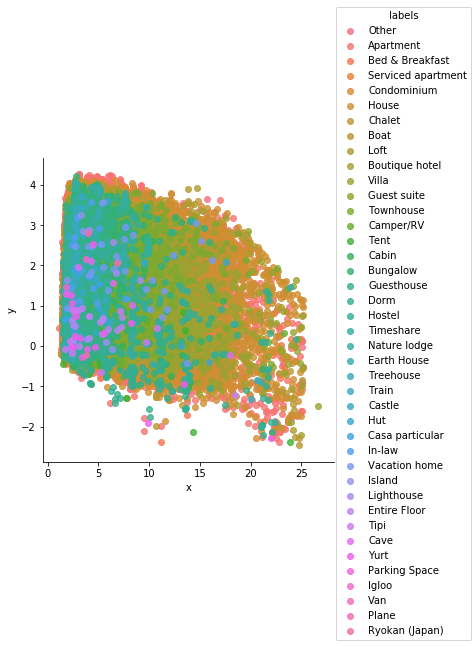

In [194]:
sns.lmplot(x='x', y='y', data=compressed_pca, hue='labels', fit_reg=False)